In [1]:
%pylab inline
from scipy.interpolate import interpn
from helpFunctions import surfacePlot
import numpy as np
from multiprocessing import Pool
from functools import partial
import warnings
import math
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


### The value of renting
Assuming we obtain the value: $\tilde{V}_{t+1}(x_{t+1})$ where:   
$x_{t+1} = [w_{t+1}, n_{t+1}, M_{t+1}, g_{t+1} = 0, e_{t+1}, s_{t+1}, (H)]$  from interpolation. We know $H$ and $M_t$ from the action taken and we could calculate mortgage payment $m$ and $rh$ (now treated as constant) is observed from the market. 

* To start with we have state variable: $x_t = [w_t, n_t, e_t, s_t]$
* Housing choice is limited: $H_{\text{choice}} = \{750, 1000, 1500, 2000\}$ 
* Mortgage choice is also limitted to discrete values $M_{t} = [0.2H, 0.4H, 0.6H, 0.8H]$ 
* Action: continue to rent: $a = (c, b, k, h)$ switch to owning a house: $a = (c, b, k, M, H)$
* Buying house activities can only happend during the age of 10 and 25.

In [2]:
# time line
T_min = 0
T_max = 70
T_R = 45
# discounting factor
beta = 1/(1+0.02)
# utility function parameter 
gamma = 2
# relative importance of housing consumption and non durable consumption 
alpha = 0.8
# parameter used to calculate the housing consumption 
kappa = 0.3
# depreciation parameter 
delta = 0.025
# housing parameter 
chi = 0.3
# uB associated parameter
B = 2
# constant cost 
c_h = 0.5
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate
r_b = np.array([0.03 ,0.05])
# stock return depends on current and future econ states
# r_k = np.array([[-0.2, 0.15],[-0.15, 0.2]])
r_k = np.array([[-0.15, 0.20],[-0.15, 0.20]])
# expected return on stock market
# r_bar = 0.0667
r_bar = 0.02
# probability of survival
Pa = np.load("prob.npy")
# deterministic income
detEarning = np.load("detEarning.npy")
# probability of employment transition Pe[s, s_next, e, e_next]
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1

# some variables associate with 401k amount
Nt = [np.sum(Pa[t:]) for t in range(T_max-T_min)]
Dt = [np.ceil(((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)) for N in Nt]
# income fraction goes into 401k 
yi = 0.005
# mortgate rate 
rh = 0.036
# this discount is used to calculate mortgage payment m 
D = [((1+rh)**N - 1)/(rh*(1+rh)**N) for N in range(T_max-T_min)]
# housing price constant 
pt = 2*250/1000
# renting price constant 
pr = 2*30/1000
H_options = [1000, 2000]
M_options = [0.2, 0.5, 0.8]

In [3]:
#Define the utility function
def u(c):
    # shift utility function to the left, so it only takes positive value
    return (np.float_power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
def uB(tb):
    return B*u(tb)

#Calculate TB_rent
def calTB_rent(x):
    # change input x as numpy array
    # w, n, e, s = x
    TB = x[:,0] + x[:,1]
    return TB

#Calculate TB_own 
def calTB_own(x):
    # change input x as numpy array
    # transiton from (w, n, e, s) -> (w, n, M, 0, e, s, H)
    TB = x[:,0] + x[:,1] + x[:,6]*pt - x[:,2]
    return TB

def u_rent(a):
    '''
    Input:
        action a: c, b, k, h = a 
    Output: 
        reward value: the length of return should be equal to the length of a
    '''
    c = a[:,0]
    h = a[:,3]
    C = np.float_power(c, alpha) * np.float_power(h, 1-alpha)
    return u(C)

def u_own(a):
    '''
    Input:
        action a: c, b, k, M, H = a
    Output: 
        reward value: the length of return should be equal to the length of a
    '''
    c = a[:,0]
    H = a[:,4]
    C = np.float_power(c, alpha) * np.float_power((1+kappa)*H, 1-alpha)
    return u(C)

#Define the earning function, which applies for both employment and unemployment, good econ state and bad econ state 
def y(t, x):
    w, n, e, s = x
    if t <= T_R:
        welfare = 5
        return detEarning[t] * earningShock[int(s)] * e + (1-e) * welfare
    else:
        return detEarning[t]
    
#Earning after tax and fixed by transaction in and out from 401k account 
def yAT(t,x):
    yt = y(t, x)
    w, n, e, s = x
    if t <= T_R and e == 1:
        # 5% of the income will be put into the 401k 
        return (1-tau_L)*(yt * (1-yi))
    if t <= T_R and e == 0:
        return yt
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + n/Dt[t]

#Define the evolution of the amount in 401k account 
def gn(t, n, x, s_next):
    w, n, e, s = x
    if t <= T_R and e == 1:
        # if the person is employed, then 5 percent of his income goes into 401k 
        n_cur = n + y(t, x) * yi
    elif t <= T_R and e == 0:
        # if the perons is unemployed, then n does not change 
        n_cur = n
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = n - n/Dt[t]
    return (1+r_k[int(s), s_next])*n_cur 

In [4]:
def transition_to_rent(x,a,t):
    '''
        imput a is np array constains all possible actions 
        from x = [w, n, e, s] to x = [w, n, e, s]
    '''
    w, n, e, s = x
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    for aa in a:
        c, b, k, h = aa
        for s_next in [0,1]:
                w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[int(s), s_next])
                n_next = gn(t, n, x, s_next)
                if t >= T_R:
                    e_next = 0
                    x_next.append([w_next, n_next, e_next, s_next])
                    prob_next.append(Ps[int(s),s_next])
                else:
                    for e_next in [0,1]:
                        x_next.append([w_next, n_next, e_next, s_next])
                        prob_next.append(Ps[int(s),s_next] * Pe[int(s),s_next,int(e),e_next])
    return np.array(x_next), np.array(prob_next)    
  

def transition_to_own(x,a,t):
    '''
        imput a is np array constains all possible actions 
        from x = [w, n, e, s] to x = [w, n, M, g=0, e, s, H]
    '''
    w, n, e, s = x
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    for aa in a:
        c, b, k, M, H = aa
        M_next = M*(1+rh)
        for s_next in [0,1]:
                w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[int(s), s_next])
                n_next = gn(t, n, x, s_next)
                if t >= T_R:
                    e_next = 0
                    x_next.append([w_next, n_next, M_next, 0, e_next, s_next, H])
                    prob_next.append(Ps[int(s),s_next])
                else:
                    for e_next in [0,1]:
                        x_next.append([w_next, n_next, M_next, 0, e_next, s_next, H])
                        prob_next.append(Ps[int(s),s_next] * Pe[int(s),s_next,int(e),e_next])
    return np.array(x_next), np.array(prob_next)

In [5]:
# used to calculate dot product
def dotProduct(p_next, uBTB, t):
    if t >= T_R:
        return (p_next*uBTB).reshape((len(p_next)//2,2)).sum(axis = 1)
    else:
        return (p_next*uBTB).reshape((len(p_next)//4,4)).sum(axis = 1)
    
# Value function is a function of state and time, according to the restriction transfer from renting to ownning can only happen
# between the age: 10 - 25
def V(x, t, NN):
    w, n, e, s = x
    yat = yAT(t,x)
    
    # first define the objective function solver and then the objective function
    def obj_solver_rent(obj_rent):
    # a = [c, b, k, h] 
    # Constrain: yat + w = c + b + k + pr*h
    # h_portion takes [0:0.05:0.95]
    # c_portion takes remaining [0:0.05:0.95]
    # b_portion takes reamining [0:0.05:0.95]
    # k is the remainder 
        actions = []
        for hp in np.linspace(0,0.99,20):
            budget1 = yat + w
            h = budget1 * hp/pr
            budget2 = budget1 * (1-hp)
            for cp in np.linspace(0,1,11):
                c = budget2*cp
                budget3 = budget2 * (1-cp)
                for bp in np.linspace(0,1,11):
                    b = budget3* bp
                    k = budget3 * (1-bp)
                    # q = 1 not renting in this case 
                    actions.append([c,b,k,h])
                    
        actions = np.array(actions)
        values = obj_rent(actions)
        fun = np.max(values)
        ma = actions[np.argmax(values)]
        return fun, ma            
                    
    def obj_solver_own(obj_own):
    # a = [c, b, k, M, H]
    # possible value of H = {750, 1000, 1500, 2000} possible value of [0.2H, 0.4H, 0.6H, 0.8H]]*pt
    # (M, t, rh) --> m 
    # Constrain: yat + w = c + b + k + (H*pt - M) + ch
        actions = []
        for H in H_options:
            for mp in M_options:
                M = mp*H*pt
                m = M/D[T_max - t - 1]
                # 5 is the welfare income which is also the minimum income
                if (H*pt - M) + c_h <= yat + w and m < pr*H + 5:
                    budget1 = yat + w - (H*pt - M) - c_h
                    # c_portion takes remaining [0:0.05:0.95]
                    # b_portion takes reamining [0:0.05:0.95]
                    # k is the remainder
                    for cp in np.linspace(0,1,11):
                        c = budget1*cp
                        budget2 = budget1 * (1-cp)
                        for bp in np.linspace(0,1,11):
                            b = budget2* bp
                            k = budget2 * (1-bp)
                            actions.append([c,b,k,M,H])            
            if len(actions) == 0:
                return -np.inf, [0,0,0,0,0]
            else:
                actions = np.array(actions)
                values = obj_own(actions)
                fun = np.max(values)
                ma = actions[np.argmax(values)]
                return fun, ma
    
    if t == T_max-1:
        # The objective function of renting
        def obj_rent(actions): 
            # a = [c, b, k, h]
            x_next, p_next  = transition_to_rent(x, actions, t)
            uBTB = uB(calTB_rent(x_next)) 
            return u_rent(actions) + beta * dotProduct(uBTB, p_next, t) 

        fun, action = obj_solver_rent(obj_rent)
        return np.array([fun, action])

    elif t < 10 or t > 25:
        # The objective function of renting
        def obj_rent(actions):
            # a = [c, b, k, h]
            x_next, p_next  = transition_to_rent(x, actions, t)
            V_tilda = NN.predict(x_next) # V_rent_{t+1} used to approximate, shape of x is [w,n,e,s]
            uBTB = uB(calTB_rent(x_next))
            return u_rent(actions) + beta * (Pa[t] * dotProduct(V_tilda, p_next, t) + (1 - Pa[t]) * dotProduct(uBTB, p_next, t))

        fun, action = obj_solver_rent(obj_rent)
        return np.array([fun, action])

    else:
        # The objective function of renting
        def obj_rent(actions):
            # a = [c, b, k, h]
            x_next, p_next  = transition_to_rent(x, actions, t)
            V_tilda = NN.predict(x_next) # V_rent_{t+1} used to approximate, shape of x is [w,n,e,s]
            uBTB = uB(calTB_rent(x_next))
            return u_rent(actions) + beta * (Pa[t] * dotProduct(V_tilda, p_next, t) + (1 - Pa[t]) * dotProduct(uBTB, p_next, t))
        # The objective function of owning
        def obj_own(actions):
            # a = [c, b, k, M, H]
            x_next, p_next  = transition_to_own(x, actions, t)
            V_tilda = NN.predict(x_next) # V_own_{t+1} used to approximate, shape of x is [w,n,0,e,s,H,M]
            uBTB = uB(calTB_own(x_next))
            return u_own(actions) + beta * (Pa[t] * dotProduct(V_tilda, p_next, t) + (1 - Pa[t]) * dotProduct(uBTB, p_next, t))

        fun1, action1 = obj_solver_rent(obj_rent)
        fun2, action2 = obj_solver_own(obj_own)
        if fun1 > fun2:
            return np.array([fun1, action1])
        else:
            return np.array([fun2, action2])

In [6]:
# wealth discretization 
ws = np.array([10,25,50,75,100,125,150,175,200,250,500,750,1000,1500,3000])
w_grid_size = len(ws)
# 401k amount discretization 
ns = np.array([1, 5, 10, 15, 25, 40, 65, 100, 150, 300, 400,1000])
n_grid_size = len(ns)

xgrid = np.array([[w, n, e, s]
                            for w in ws
                            for n in ns
                            for e in [0,1]
                            for s in [0,1]
                            ]).reshape((w_grid_size, n_grid_size,2,2,4))

Vgrid = np.zeros((w_grid_size, n_grid_size,2,2, T_max-T_min))
cgrid = np.zeros((w_grid_size, n_grid_size,2,2, T_max-T_min))
bgrid = np.zeros((w_grid_size, n_grid_size,2,2, T_max-T_min))
kgrid = np.zeros((w_grid_size, n_grid_size,2,2, T_max-T_min))
hgrid = np.zeros((w_grid_size, n_grid_size,2,2, T_max-T_min))
# Policy function of buying a house 
Mgrid = np.zeros((w_grid_size, n_grid_size,2,2, T_max-T_min))
Hgrid = np.zeros((w_grid_size, n_grid_size,2,2, T_max-T_min))

In [7]:
V1000 = np.load("Vgrid1000.npy")
V2000 = np.load("Vgrid2000.npy")
Vown = [V1000,V2000]
Hs = [1000,2000]

In [8]:
class iApproxy(object):
    def __init__(self, pointsRent, Vrent, Vown, t):
        self.Vrent = Vrent 
        self.Vown = Vown
        self.Prent = pointsRent
        self.t = t
    def predict(self, xx):
        if xx.shape[1] == 4:
            # x = [w, n, e, s]
            pvalues = np.zeros(xx.shape[0])
            index00 = (xx[:,2] == 0) & (xx[:,3] == 0) 
            index01 = (xx[:,2] == 0) & (xx[:,3] == 1)
            index10 = (xx[:,2] == 1) & (xx[:,3] == 0)
            index11 = (xx[:,2] == 1) & (xx[:,3] == 1)
            pvalues[index00]=interpn(self.Prent, self.Vrent[:,:,0,0], xx[index00][:,:2], bounds_error = False, fill_value = None)
            pvalues[index01]=interpn(self.Prent, self.Vrent[:,:,0,1], xx[index01][:,:2], bounds_error = False, fill_value = None)
            pvalues[index10]=interpn(self.Prent, self.Vrent[:,:,1,0], xx[index10][:,:2], bounds_error = False, fill_value = None)
            pvalues[index11]=interpn(self.Prent, self.Vrent[:,:,1,1], xx[index11][:,:2], bounds_error = False, fill_value = None)
            return pvalues
        else: 
            # x = w, n, M, g=0, e, s, H
            pvalues = np.zeros(xx.shape[0])
            for i in range(len(Hs)):
                H = Hs[i]
                # Mortgage amount, * 0.25 is the housing price per unit
                Ms = np.array([0.01*H,0.05*H,0.1*H,0.2*H,0.3*H,0.4*H,0.5*H,0.6*H,0.7*H,0.8*H]) * pt
                points = (ws,ns,Ms)
                index00 = (xx[:,4] == 0) & (xx[:,5] == 0) & (xx[:,6] == H) 
                index01 = (xx[:,4] == 0) & (xx[:,5] == 1) & (xx[:,6] == H)
                index10 = (xx[:,4] == 1) & (xx[:,5] == 0) & (xx[:,6] == H)
                index11 = (xx[:,4] == 1) & (xx[:,5] == 1) & (xx[:,6] == H)
                pvalues[index00]=interpn(points, self.Vown[i][:,:,:,0,0,0,self.t], xx[index00][:,:3], method = "nearest",bounds_error = False, fill_value = None)
                pvalues[index01]=interpn(points, self.Vown[i][:,:,:,0,0,1,self.t], xx[index01][:,:3], method = "nearest",bounds_error = False, fill_value = None)
                pvalues[index10]=interpn(points, self.Vown[i][:,:,:,0,1,0,self.t], xx[index10][:,:3], method = "nearest",bounds_error = False, fill_value = None)
                pvalues[index11]=interpn(points, self.Vown[i][:,:,:,0,1,1,self.t], xx[index11][:,:3], method = "nearest",bounds_error = False, fill_value = None)
            return pvalues

In [9]:
%%time
# value iteration part 
xs = xgrid.reshape((w_grid_size*n_grid_size*2*2,4))
pool = Pool()
pointsRent = (ws, ns)
for t in range(T_max-1,T_min, -1):
    print(t)
    if t == T_max - 1:
        f = partial(V, t = t, NN = None)
        results = np.array(pool.map(f, xs))
    else:
        approx = iApproxy(pointsRent,Vgrid[:,:,:,:,t+1], Vown, t+1)
        f = partial(V, t = t, NN = approx)
        results = np.array(pool.map(f, xs))
        
    # here results need some clean up due to different length of the actions taken.
    # a = [c,b,k,h] or a = [c,b,k,M,H]
    Vgrid[:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size,2,2))
    cgrid[:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,2,2))
    bgrid[:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,2,2))
    kgrid[:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,2,2))
    # if a = [c, b, k, h]
    hgrid[:,:,:,:,t] = np.array([r[3] if len(r) == 4 else r[4] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,2,2))
    # if a = [c, b, k, M, H]
    Mgrid[:,:,:,:,t] = np.array([r[3] if len(r) == 5 else 0 for r in results[:,1]]).reshape((w_grid_size,n_grid_size,2,2))
    Hgrid[:,:,:,:,t] = np.array([r[4] if len(r) == 5 else 0 for r in results[:,1]]).reshape((w_grid_size,n_grid_size,2,2))
pool.close()

69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
CPU times: user 5min 11s, sys: 6min 25s, total: 11min 36s
Wall time: 16min 54s


In [10]:
for tt in range(10,25):
    print(Hgrid[:,1,1,1,tt])

[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 100

In [11]:
for tt in range(10,25):
    print(Hgrid[:,1,0,1,tt])

[   0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 100

In [12]:
for tt in range(10,25):
    print(Hgrid[:,1,1,0,tt])

[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
    0. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]
[   0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 100

In [13]:
for tt in range(10,25):
    print(Mgrid[:,1,0,0,tt])

[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400

In [14]:
for tt in range(10,25):
    print(Mgrid[:,1,1,1,tt])

[  0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400.]
[  0.   0.   0. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400

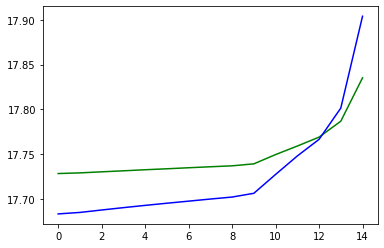

In [17]:
plt.plot(V2000[:,0,0,0,1,1,10], 'g')
plt.plot(V1000[:,0,0,0,1,1,10], 'b')

In [ ]:
plt.plot(V2000[:,5,0,0,1,1,10], 'g')
plt.plot(V1500[:,5,0,0,1,1,10], 'y')
plt.plot(V1000[:,5,0,0,1,1,10], 'b')
plt.plot(V750[:,5,0,0,1,1,10], 'r')

In [ ]:
plt.plot(V2000[:,1,0,0,1,1,10],'r')
plt.plot(V2000[:,1,4,0,1,1,10],'g')
plt.plot(V2000[:,1,8,0,1,1,10],'b')

In [ ]:
plt.plot(V750[:,1,0,0,1,1,10], 'r')
plt.plot(V750[:,1,4,0,1,1,10], 'g')
plt.plot(V750[:,1,8,0,1,1,10], 'b')